In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Ukuran dataset asli: (515344, 91)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515344 entries, 0 to 515343
Data columns (total 91 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   2001        515344 non-null  int64  
 1   49.94357    515344 non-null  float64
 2   21.47114    515344 non-null  float64
 3   73.0775     515344 non-null  float64
 4   8.74861     515344 non-null  float64
 5   -17.40628   515344 non-null  float64
 6   -13.09905   515344 non-null  float64
 7   -25.01202   515344 non-null  float64
 8   -12.23257   515344 non-null  float64
 9   7.83089     515344 non-null  float64
 10  -2.46783    515344 non-null  float64
 11  3.32136     515344 non-null  float64
 12  -2.31521    515344 non-null  float64
 13  10.20556    515344 non-null  float64
 14  611.10913   515344 non-null  float64
 15  951.0896    515344 non-null  float64
 16  698.11428   515344 non-null  float64
 17  408.98485   515344 non-null  float64
 18  383.70912 

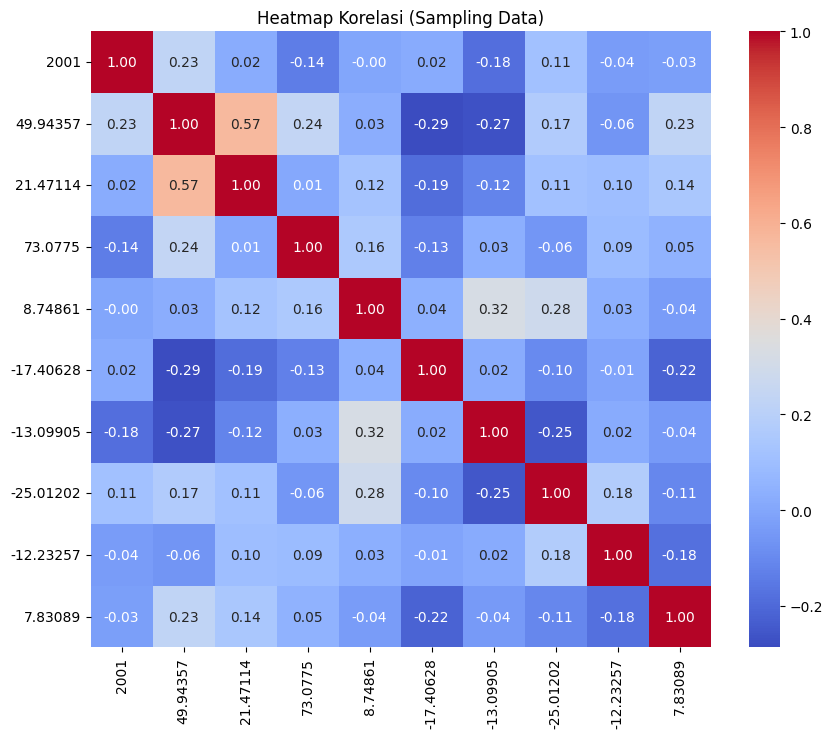

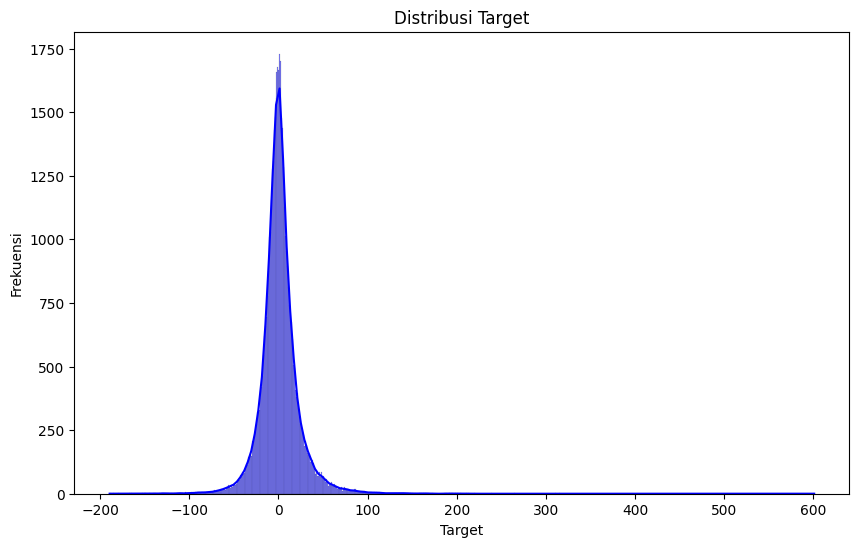

Jumlah fitur setelah seleksi: 10
Mean prediction for Decision Tree: 1.467975323174112

Tuning model: poly
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for poly: {'model__max_depth': 5, 'poly__degree': 3}
MSE on test set for poly: 359.6742071942899

Tuning model: tree
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for tree: {'model__max_depth': 5, 'model__min_samples_split': 2}
MSE on test set for tree: 414.3344335332493

Tuning model: knn
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for knn: {'model__n_neighbors': 10, 'model__weights': 'distance'}
MSE on test set for knn: 322.2420856478689

Tuning model: xgb
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best parameters for xgb: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
MSE on test set for xgb: 274.11227729127756

Tuning model: poly
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Be

In [14]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib

# 1. Load Dataset
# Load dataset (assume no column headers; add them manually if needed)
df = pd.read_csv('/content/drive/MyDrive/Dataset/RegresiUTSTelkom.csv')

# Informasi awal dataset
print("Ukuran dataset asli:", df.shape)
print(df.info())

# 2. Sampling Dataset (gunakan 10% dari total data)
df_sample = df.sample(frac=0.1, random_state=42)
print("Ukuran dataset setelah sampling:", df_sample.shape)

# 3. Exploratory Data Analysis (EDA)
print("Statistik Deskriptif Dataset:")
print(df_sample.describe())

# Sampling dataset (gunakan 10% dari total data)
df_sample = df.sample(frac=0.1, random_state=42)

# Menghitung korelasi
corr_matrix = df_sample.corr()

# Memilih hanya beberapa kolom (misalnya, 10 kolom pertama)
columns_to_plot = corr_matrix.columns[:10]  # Pilih 10 kolom pertama untuk contoh
filtered_corr_matrix = corr_matrix.loc[columns_to_plot, columns_to_plot]

# Plot heatmap korelasi yang lebih rapi
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi (Sampling Data)')
plt.show()

# Visualisasi distribusi target
target_column_name = df_sample.columns[-1]  # Anggap kolom terakhir sebagai target
plt.figure(figsize=(10, 6))
sns.histplot(df_sample[target_column_name], kde=True, color='blue')
plt.title('Distribusi Target')
plt.xlabel('Target')
plt.ylabel('Frekuensi')
plt.show()

# 4. Data Preprocessing
# Memisahkan fitur (X) dan target (y)
X = df_sample.drop(columns=[target_column_name])  # Drop target column
y = df_sample[target_column_name]  # Select target column

# Feature selection (pilih 10 fitur terbaik berdasarkan korelasi dengan target)
selector = SelectKBest(score_func=f_regression, k=10)
X_selected = selector.fit_transform(X, y)

print("Jumlah fitur setelah seleksi:", X_selected.shape[1])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# 5. Pipeline Definition
pipelines = {
    'poly': Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    'tree': Pipeline([
        ('scaler', StandardScaler()),
        ('model', DecisionTreeRegressor(random_state=42))
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor())
    ]),
    'xgb': Pipeline([
        ('scaler', StandardScaler()),
        # Change tree_method to 'hist' to use CPU instead of GPU
        ('model', XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42))
    ])
}

# 6. Hyperparameter Tuning
param_grid = {
    'poly': {
        'poly__degree': [2, 3],
        'model__max_depth': [3, 5, 7]
    },
    'tree': {
        'model__max_depth': [3, 5, 7],
        'model__min_samples_split': [2, 5, 10]
    },
    'knn': {
        'model__n_neighbors': [3, 5, 10],
        'model__weights': ['uniform', 'distance']
    },
    'xgb': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

# Cek jika model Decision Tree ada dalam best_models
if 'tree' in best_models:
    decision_tree_model = best_models['tree']
    y_pred_tree = decision_tree_model.predict(X_test)  # Prediksi pada data test
    mean_pred_tree = np.mean(y_pred_tree)  # Hitung nilai mean dari prediksi
    print(f"Mean prediction for Decision Tree: {mean_pred_tree}\n")

# Tuning and evaluation
best_models = {}
for name, pipeline in pipelines.items():
    print(f"Tuning model: {name}")
    grid = GridSearchCV(pipeline, param_grid[name], cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    # Evaluasi model
    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"MSE on test set for {name}: {mse}\n")

best_models = {}
for name, pipeline in pipelines.items():
    print(f"Tuning model: {name}")
    grid = GridSearchCV(pipeline, param_grid[name], cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_

    # Evaluasi model
    y_pred = grid.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Best parameters for {name}: {grid.best_params_}")
    print(f"MSE on test set for {name}: {mse}\n")

# 7. Save Best Model
joblib.dump(best_models['xgb'], 'best_xgb_model.pkl')
print("Best XGB model saved.")

<Figure size 1000x800 with 0 Axes>

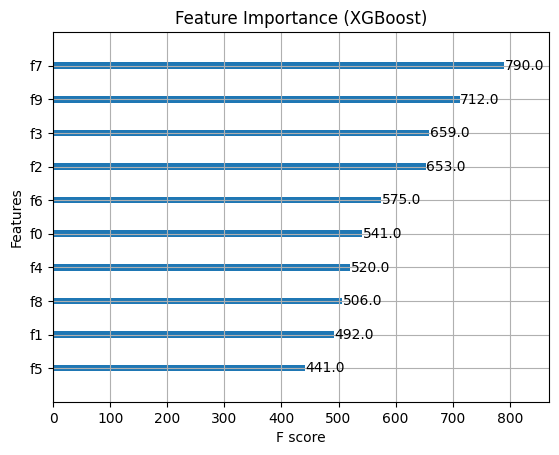

In [4]:
# Visualisasi Feature Importance untuk XGBoost
from xgboost import plot_importance # Import the plot_importance function

xgb_model = best_models['xgb']['model'] # Access the XGBRegressor model correctly
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight') # Use plot_importance directly
plt.title('Feature Importance (XGBoost)')
plt.show()